In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import warnings
warnings.filterwarnings('ignore')

### Задание 1

In [3]:
data = pd.read_csv("data.csv")
data.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


### Задание 2

In [4]:
data.rename(columns = {'conversion': 'target', 'offer': 'treatment'}, inplace = True)
data.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
data['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [6]:
data.replace({'treatment': {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}}, inplace = True)
data['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

### Задание 3

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis = 1), data['target'], test_size = 0.3,
                                                    random_state = 41)

### Задание 4

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [9]:
cat_features = ['zip_code', 'channel']

### Задание 5

In [10]:
treatment_train = X_train['treatment']
treatment_test = X_test['treatment']

X_train.drop(columns = 'treatment', inplace = True)
X_test.drop(columns = 'treatment', inplace = True)

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### С признаком коммуникации (S learner)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026D979033C8>,
      dtype=object)

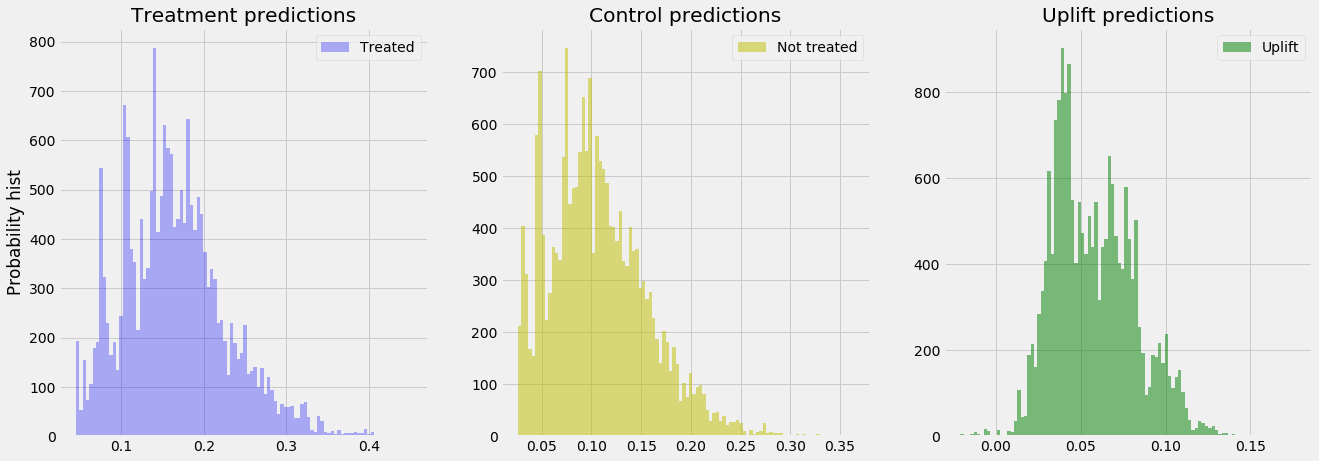

In [11]:
sm = SoloModel(CatBoostClassifier(iterations = 20, thread_count = 2, random_state = 41, silent = True))
sm = sm.fit(X_train, y_train, treatment_train, estimator_fit_params = {'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

#### С трансформацией таргета

In [12]:
ct = ClassTransformation(CatBoostClassifier(iterations = 20, thread_count = 2, random_state = 41, silent = True))
ct = ct.fit(X_train, y_train, treatment_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treatment_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treatment_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

#### С двумя независимыми моделями

In [13]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

tm = tm.fit(
    X_train, y_train, treatment_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treatment_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treatment_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

### Задание 6

In [14]:
pd.DataFrame(data = models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.095521,0.085532
1,ClassTransformation,0.112801,0.075665
2,TwoModels,0.095693,0.069473


Модель с трансформацией таргета выглядит наиболее удачной

### Задание 7

In [15]:
X_train_tr = pd.concat([X_train.drop(cat_features, 1), pd.get_dummies(X_train[cat_features], prefix = cat_features)], 1)
features = [col for col in X_train_tr]

In [16]:
%%time

uplift_model = UpliftTreeClassifier(max_depth = 8, min_samples_leaf = 200, min_samples_treatment = 50,
                                    n_reg = 100, evaluationFunction = 'KL', control_name = 'control')

uplift_model.fit(X_train_tr.values, treatment = treatment_train.map({1: 'treatment1', 0: 'control'}).values, y = y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

Wall time: 15.7 s
